# PSMA monthly analysis

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import pycountry_convert

In [7]:
wd = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/'

In [8]:
port_visits = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')
top_10_percent = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_12087/1022794205.py:1: DtypeWarning: Columns (6,7,8,9,12,22,25,26,29,33,34,35,37,38,41,42,43,44,46,47,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  port_visits = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_12087/1022794205.py:2: DtypeWarning: Columns (11,12,13,14,15,42,43,44,47) have mixed types. Specify dtype option on import or set low_memory=False.
  top_10_percent = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')


In [9]:
port_visit_top10 = port_visits.loc[port_visits['vessel_id'].isin(top_10_percent['vessel.id']),:].reset_index(drop=True)

In [10]:
port_visit_top10['datetime'] = pd.to_datetime(port_visit_top10['event_start'])
port_visit_top10['months_since_jan_2012'] = (port_visit_top10['datetime'].dt.year - 2012) * 12 + port_visit_top10['datetime'].dt.month - 1

In [11]:
psma_entry = pd.read_excel(
    '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/Law_Review/Law Review2.xlsx',
    sheet_name = 'PSMA'
)
psma_entry.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace = True)
psma_entry.columns = ['Country', 'Signature', 'Ratification', 'Status']
psma_entry['rat_year'] = psma_entry['Ratification'].str[:4].fillna(0).astype(int)
psma_entry['rat_year'] = psma_entry['rat_year'].replace(0,np.nan)
psma_entry['rat_month'] = psma_entry['Ratification'].str[5:7].fillna(0).astype(int)
psma_entry['rat_month'] = psma_entry['rat_month'].replace(0,np.nan)
psma_entry['psma_months_since_jan_2012'] = (psma_entry['rat_year']-2012) * 12 + psma_entry['rat_month'] - 1
psma_entry = psma_entry.loc[psma_entry['rat_year']>=2015,:] 
psma_entry = psma_entry.loc[psma_entry['rat_year']<=2019,:] 
psma_entry.head()

,Country,Signature,Ratification,Status,rat_year,rat_month,psma_months_since_jan_2012
0,ALB,NaT,2017-04-07 ACS,False,2017.0,4.0,63.0
2,AUS,2010-04-27,2015-07-20 RAT,True,2015.0,7.0,42.0
3,BHS,NaT,2016-10-07 ACS,False,2016.0,10.0,57.0
4,BGD,NaT,2019-12-20 ACS,False,2019.0,12.0,95.0
5,BRB,NaT,2016-02-02 ACS,False,2016.0,2.0,49.0


# Port visits in countries not ratified PSMA

In [12]:
plot_data1 = port_visit_top10.loc[~(port_visit_top10['flag'].isin(psma_entry['Country'])),:]
plot_data1 = plot_data1.groupby(['flag','months_since_jan_2012'])['event_id'].count().reset_index()

<AxesSubplot: xlabel='months_since_jan_2012', ylabel='event_id'>

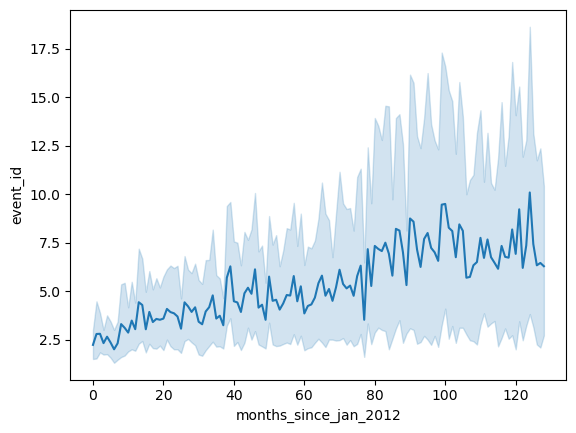

In [13]:
sns.lineplot(plot_data1,x='months_since_jan_2012', y='event_id')

# Port visits in countries that ratified PSMA

In [14]:
plot_data2 = port_visit_top10.loc[port_visit_top10['flag'].isin(psma_entry['Country']),:]
plot_data2 = plot_data2.merge(psma_entry, left_on='flag', right_on='Country', how='left')
plot_data2['months_since_PSMA'] = plot_data2['months_since_jan_2012'] - plot_data2['psma_months_since_jan_2012']
plot_data2['years_since_PSMA'] = plot_data2['months_since_PSMA'] // 12
plot_data2 = plot_data2.groupby(['flag','years_since_PSMA'])['event_id'].count().reset_index()

deleting first and last values

In [15]:
first_year = plot_data2.groupby('flag')['years_since_PSMA'].min().reset_index()
last_year = plot_data2.groupby('flag')['years_since_PSMA'].max().reset_index()
first_year['to_delete1'] = 1
last_year['to_delete2'] = 1
plot_data2 = plot_data2.merge(first_year, on=['flag', 'years_since_PSMA'], how='left')
plot_data2 = plot_data2.merge(last_year, on=['flag', 'years_since_PSMA'], how='left')
plot_data2 = plot_data2.loc[~(plot_data2['to_delete1']==1),:]
plot_data2 = plot_data2.loc[~(plot_data2['to_delete2']==1),:]

<AxesSubplot: xlabel='years_since_PSMA', ylabel='event_id'>

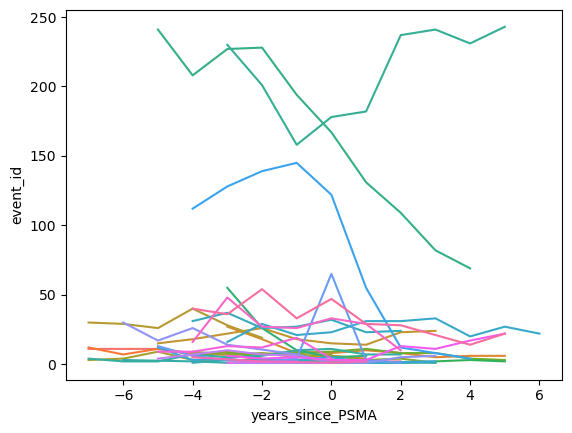

In [16]:
sns.lineplot(plot_data2,x='years_since_PSMA', y='event_id', hue='flag', legend=False)

normalising

In [17]:
plot_data3 = plot_data2.copy()
visits_in_rat_year = plot_data3.loc[plot_data3['years_since_PSMA']==0,:]
plot_data3['visits_normalised'] = np.nan
for country in plot_data3['flag'].unique():
    if country in visits_in_rat_year['flag'].unique():
        plot_data3.loc[plot_data3['flag'] == country,'visits_normalised'] = \
            100 * plot_data3.loc[plot_data3['flag'] == country,'event_id'] / float(visits_in_rat_year.loc[visits_in_rat_year['flag'] == country,'event_id'])

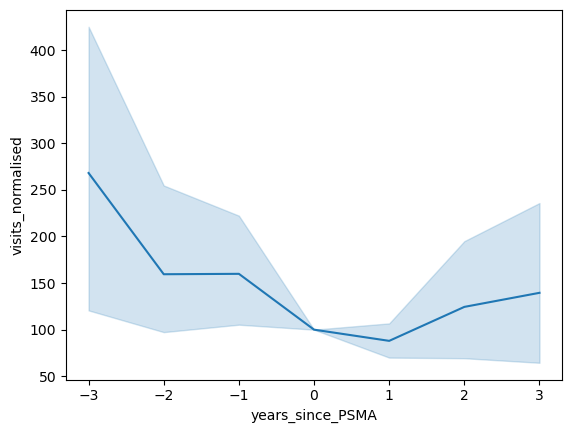

In [18]:
plot_data5 = plot_data3.copy()
plot_data5 = plot_data5.loc[plot_data5['years_since_PSMA'] >= -3,:]
plot_data5 = plot_data5.loc[plot_data5['years_since_PSMA'] <= 3,:]
sns.lineplot(plot_data5,x='years_since_PSMA', y='visits_normalised', legend=False)
plt.show()

filtering for most visited countries

In [19]:
ten_year_sum = plot_data3.groupby('flag')['event_id'].sum().reset_index()
filter = ten_year_sum.loc[ten_year_sum['event_id'] >= 200, 'flag']

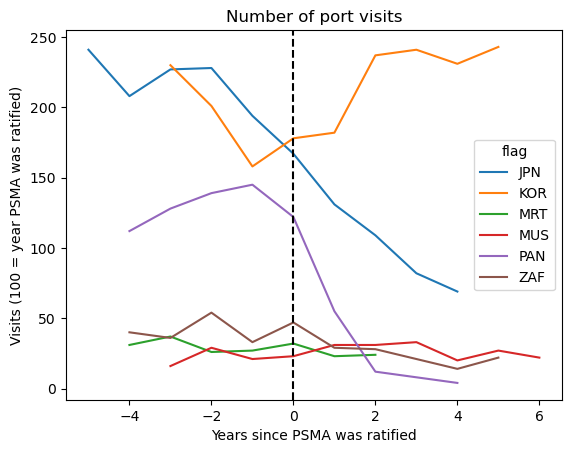

In [20]:
plot_data4 = plot_data3.copy() 
plot_data4 = plot_data4.loc[plot_data4['flag'].isin(filter),:]
sns.lineplot(plot_data4,x='years_since_PSMA', y='event_id', hue='flag', legend=True)
plt.title('Number of port visits')
plt.xlabel('Years since PSMA was ratified')
plt.ylabel('Visits (100 = year PSMA was ratified)')
plt.axvline(0, 0,1, color='black', linestyle='--')
plt.show()

Absolute values

In [23]:
country_data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]
country_data = pd.DataFrame(country_data, columns=['alpha_3', 'alpha_2', 'flag_country'])


pycountry_convert.country_alpha2_to_continent_code

,alpha_3,alpha_2,flag_country
0,ABW,AW,Aruba
1,AFG,AF,Afghanistan
2,AGO,AO,Angola
3,AIA,AI,Anguilla
4,ALA,AX,Åland Islands
...,...,...,...
244,WSM,WS,Samoa
245,YEM,YE,Yemen
246,ZAF,ZA,South Africa
247,ZMB,ZM,Zambia
